In [1]:
# Library import
import math
import numpy as np
#OpenCV for face detection
import cv2
#os to work with images
import os
#The glob module finds all the pathnames matching a specified pattern
import glob
#dlib for face detection
import dlib
#csv to work with csv file
import csv
import pandas as pd
from keras.preprocessing import image
from skimage import exposure
from skimage import feature
from imutils import paths
import argparse
import imutils
#to create the confusion matrices to assess the ML models
from sklearn.metrics import confusion_matrix
#to create the multi-layer perception neural network classifiers
from sklearn.neural_network import MLPClassifier
#to randomly shuffle the lists
from random import shuffle
#to create the support vector machine models
from sklearn import svm
#to calculate the cross-validation scores
from sklearn.model_selection import cross_val_score
#to plot the graphs
import matplotlib.pyplot as plt
#to create the learning curves
from sklearn.model_selection import learning_curve


Using TensorFlow backend.


The following code block defines a function to plot the learning curves, which is used to assess the algorithms chosen for the tasks. The function is obtained from: 
https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Image extraction
The following code blocks defines an algorithm to extract the images
from the dataset folder. The images are extracted in numerical order.
During the image extraction, the landmarks for each image are detected.
For the images, where the landmarks cannot be detected, there is a list
'images_to_remove', which keeps the paths to these images. The rest of
the images are extracted by the 'images_to_keep' list, which holds the
paths to these images and 'landmark_features' list, which holds the
coordinates of the detected landmarks for every image in the 
'images_to_keep' list.

In [158]:
# Open and store images and images paths

#Definition of the folder direction that contains all images
#This folder must be in the same folder as the notebook code file
#This folder must contain exactly 5000 images, which were provided
imgs_dir = "C:/Users/ching/Desktop/Assignment/dataset/"
#Name of the file, which contains labels for the images.
#The file has to be in the same folder as the code file.
attribute_list_filename = 'attribute_list.csv'
#Array, which will contain paths of the images
imgs = []
for i in range (1, 5001):
        imgs_path = os.path.join(imgs_dir + str(i) + ".png")
        imgs.extend(glob.glob(imgs_path))


In [159]:
# This block is based on the landmarks.py code from the Applied Machine Learning Systems
# Laboratory Exercise 2. The difference is in the image_path definition. In this version
# The image paths are extracted in numerical order from 1.png to 5000.png

global basedir, image_paths, target_size

#Definition of the folder, where the images are located
basedir = './dataset'
images_dir = "C:/Users/ching/Desktop/Assignment/dataset/"
labels_filename = 'attribute_list.csv'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

def extract_features_labels():

#     This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
#     It also extract the gender label for each image.
#     :return:
#         landmark_features:  an array containing 68 landmark points for each image in which a face was detected
#         gender_labels:      an array containing the gender label (male=0 and female=1) for each image in
#                             which a face was detected
  
    image_paths = []
    # Images path extraction in numerical order
    for i in range (1, 5001):
            imgs_path = os.path.join(imgs_dir + str(i) + ".png")
            image_paths.extend(glob.glob(imgs_path))
    #image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]

    target_size = None
    # Extraction of the labels from the attribute_list.csv
    labels_file = open(labels_filename, 'r')
    lines = labels_file.readlines()
    #gender_labels = {line.split(',')[0] : int(line.split(',')[6]) for line in lines[2:]}
    if os.path.isdir(images_dir):
        all_features = []       # List of landmarks coordinates for the images
        images_to_keep = []     # List of paths of the images, for which the landmarks are extracted
        images_to_remove = []   # List of paths of the images, for which the landmarks cannot be extracted
        for img_path in image_paths:
            file_name= img_path.split('.')[1].split('/')[-1]

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                images_to_keep.append(img_path)

                #all_labels.append(gender_labels[file_name])
            else:
                images_to_remove.append(img_path)

    landmark_features = np.array(all_features)
    return landmark_features, images_to_keep, images_to_remove#, gender_labels



In [ ]:
#landmark features, paths of the images to keep, paths of the images to remove
imgs_features, imgs_to_keep, imgs_to_remove = extract_features_labels()

In [ ]:
#Load the attributes csv file

attribute_list = pd.read_csv(attribute_list_filename)
#attribute_list[:5]

# Image class definition and the remove of the noise data
To manage all the data, the information about every remaining image will be
saved in one object of the 'Image' class. The objects of this class have
an information about the image's path, rgb and gray arrays and all the labels.
All these objects are saved into the imageList, the length of which is
the same as the number of images kept.

In [ ]:
#Define a Class to contain all info (path and attributes) of all images
class Image:
    def __init__(self, image, hair_color, eyeglasses,
                smiling, young, human, landmarks, img, gray):
        self.image = image #Image path
        self.hair_color = hair_color
        self.eyeglasses = eyeglasses
        self.smiling = smiling
        self.young = young
        self.human = human
        self.landmarks = landmarks
        self.img = img
        self.gray = gray        

In [ ]:
#create a list of Image objects

imageList = []
j=0
for i in range (0,5000):
    landmarks=[]   #extraction of the landmarks and paths of the images to be kept
    if (j < len(imgs_to_keep)):
        if (imgs[i] == imgs_to_keep[j]):
            landmarks = imgs_features[j]
            j = j+1
    img = cv2.imread(imgs[i])                      # RGB 256x256x3 image array
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   # Gray image from RGB data
    hair_color = int(attribute_list.loc[i+1][1])   # The following are the labels extraction from the attributs file
    eyeglasses = int(attribute_list.loc[i+1][2])
    smiling = int(attribute_list.loc[i+1][3])
    young = int(attribute_list.loc[i+1][4])
    human = int(attribute_list.loc[i+1][5])
    
    imageList.append(Image(imgs[i], hair_color,     # The object is created and appended to the list.
                          eyeglasses,
                          smiling,
                          young,
                          human,
                          landmarks,
                          img,
                          gray))
print("done")

The following code block identifies the images, which must be removed
from the dataset (noise images). These are from the 'images_to_remove'
list. This code save the indexes of the images in the 'imageList',
the paths of which are mentioned in 'imgs_to_remove' list

In [ ]:
j=0
removeIndex = []
for i in range (0,5000):
    if (j < len(imgs_to_remove)):
        if (imageList[i].image == imgs_to_remove[j]):
            removeIndex.append(i)
            j = j+1
        #elif (imageList[i].hair_color == -1):
            #removeIndex.append(i)

This code block deletes the images from the dataset folder to show that there is no noise data present. This block is optional, because all information about the images are already stored in 'imageList'. Therefore the code loop in the block is commented. 

In [ ]:
# for i in range (0 , len(removeIndex)):
#     os.remove(imageList[removeIndex[i]].image)
print("done")

The following block removes the images from the 'imageList'
It is done in the reverse order, so that the last images are
removed first, so that the indexes of the first images are not
changing.

In [ ]:
removeIndex.reverse()
for i in range (0 , len(removeIndex)):
    removeElement = imageList.pop(removeIndex[i])
print("done")


# Additional features extraction.
As the images are removed from the noise data, it is possible to extract
additional features, which will be used to train the models. These additional
features will be tested in the ML models i addition to the landmarks coordinates
for each task, to determine which features lead to the highest accuracy.

The following class is an extention of 'Image' class, which contains all
information of the 'Image' class features through the imageInfo variable
and information about additional features of every object in 'imageList'
of the 'Image' class.

In [ ]:
class ImageToProcess:
    def __init__(self, imageInfo, hog, hogImage, faceCenter, landmarkDistance, landmarkNormDistance, landmarkAngle):
        self.imageInfo = imageInfo                        # information about the 'Image' class features of an object
        self.hog = hog                                    # Histogram of Oriented Gradients (additional feature)
        self.hogImage = hogImage                          # Feature to keep an array of the HOG of the image, to visualize it
                                                          # it was used during the code development to check that the
                                                          # histograms are created correctly
        self.faceCenter = faceCenter                      # Coordinates of the face center according to the landmarks
        self.landmarkDistance = landmarkDistance          # Distances of the landmarks from the face center
        self.landmarkNormDistance = landmarkNormDistance  # Normalized distances
        self.landmarkAngle = landmarkAngle                # Normalized angles (relative to x-axis) of the 
                                                          #(center ---> landmark) vectors

The following block of code creates an 'imageToProcessList' list, which
keeps the data about the objects of the 'ImageToProcessList' class.

In [ ]:
imageToProcessList = []
j=0
for i in range (0,len(imageList)):

    # Extract Histogram of Oriented Gradients from the image.
    # The parameters were chosen experimentally. These parameters
    # result to the high accuracy and good learning speed of the
    # learning algorithms. The parameters can be changed, if needed
    # for future purposes.
    (hog, hogImage) = feature.hog(imageList[i].gray, orientations=9, pixels_per_cell=(32, 32),
                            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualise=True)
 
    # 'hogImage' to visualize the HOG representation of the image
    # if needed
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")
    
    # Face center coordinates are obtaine as the mean x and y values
    # of all the detected landmarks coordinates
    faceCenter = np.mean(imageList[i].landmarks,axis=0)
    
    # Variables to keep the Distances of the landmarks from the face center,
    # and angles of the (center --->landmark) vectors
    landmarkDistance = []
    landmarkNormDistance = []
    landmarkAngle = []
    
    # Maximum and minimum x and y coordinate are extracted from the landmarks
    # coordinates. These are used to calculate normalized distances
    # distance = ((x_center - x)^2 + (y_center - y)^2)^0.5
    # maxDistance = ((xmax - xmin)^2 + (ymax - ymin)^2)^0.5
    # normDistance = distance/maxDistance
    xmax = imageList[i].landmarks[0][0]
    xmin = imageList[i].landmarks[0][0]
    ymax = imageList[i].landmarks[0][1]
    ymin = imageList[i].landmarks[0][1]
    for l in range(0, len(imageList[i].landmarks)):
        if (imageList[i].landmarks[l][0] > xmax):
            xmax = imageList[i].landmarks[l][0]
        if (imageList[i].landmarks[l][0] < xmin):
            xmin = imageList[i].landmarks[l][0]
        if (imageList[i].landmarks[l][1] > ymax):
            ymax = imageList[i].landmarks[l][1]
        if (imageList[i].landmarks[l][1] < ymin):
            ymin = imageList[i].landmarks[l][1]
    maxDist = math.sqrt(pow(xmax - xmin, 2) + pow(ymax - ymin, 2))
    
    #calculation of the landmark (normalized) distances from the face center and the normalized angles
    for j in range (0, len(imageList[i].landmarks)):
        landmarkDistance.append((math.sqrt(pow(faceCenter[0] - imageList[i].landmarks[j][0], 2) 
                                           + pow(faceCenter[1] - imageList[i].landmarks[j][1], 2))))
        
        landmarkNormDistance.append((math.sqrt(pow(faceCenter[0] - imageList[i].landmarks[j][0], 2) 
                                           + pow(faceCenter[1] - imageList[i].landmarks[j][1], 2)))/maxDist)
        
        landmarkAngle.append(((math.atan2(faceCenter[1] - imageList[i].landmarks[j][1],
                                        faceCenter[0] - imageList[i].landmarks[j][0])*360)/(2*math.pi) + 180)/360)
    #Image to process objects are created and appended to the list
    imageToProcessList.append(ImageToProcess(imageList[i],
                                             hog,hogImage,
                                             faceCenter,
                                             landmarkDistance,
                                             landmarkNormDistance,
                                             landmarkAngle))
print("done")

# Creation of the training/testing data

The training and the tasting data are created by random split
of the 'imageToProcessList'. The training data consists of the
75% of the 'imageToProcessList' objects. The random split is
performed by the initial shuffle of the objects in the list
and then the division of data between training and testing.
The training images are saved to the 'trainingList',
while the test images to the 'testList'

In [14]:
#Randomized shuffle of the imageToProcessList to create a random mix of training and testing datasets 
shuffle(imageToProcessList)

In [17]:
trainingPart = 0.75
trainingList = imageToProcessList[0:int(trainingPart*np.size(imageToProcessList)) - 1]
testList = imageToProcessList[int(trainingPart*np.size(imageToProcessList)) - 1 :]
print('Total images = ',np.size(imageToProcessList))
print('Training images = ',np.size(trainingList))
print('Testing images = ',np.size(testList))

Total images =  4349
Training images =  3260
Testing images =  1089


In the following code block, all the features/labels of the images
are extracted to separate variables. This is done to ease
the data management by providing each feature/label standard
name in the following structure: (train/test) _ (fearute/label name).

print() functions are used to confirm that the data is extracted
correctly, by having an original shape

In [18]:
#array of RGB values of the imamges 256x256x3
train_img = [o.imageInfo.img for o in trainingList]
print(np.shape(train_img))

#grayscale of the image 256x256
train_gray = [o.imageInfo.gray for o in trainingList]
print(np.shape(train_gray))

#coordinates of the landmark points 68x2
train_landmarks = [o.imageInfo.landmarks for o in trainingList]
print(np.shape(train_landmarks))

#array of the HOG values of the images (size depends on the parameters set in the
#hog image creation in the imageToProcessList creation block)
train_hog = [o.hog for o in trainingList]
print(np.shape(train_hog))

#array of normalized distances 68
train_NormDist = [o.landmarkNormDistance for o in trainingList]
print(np.shape(train_NormDist))

#array of normlized angles 68
train_Angle = [o.landmarkAngle for o in trainingList]
print(np.shape(train_Angle))

#labels of smiling
train_smiling = [o.imageInfo.smiling for o in trainingList]
print(np.shape(train_smiling))

#labels of eyeglasses
train_eyeglasses = [o.imageInfo.eyeglasses for o in trainingList]
print(np.shape(train_eyeglasses))

#lables of haircolor
train_hair_color = [o.imageInfo.hair_color for o in trainingList]
print(np.shape(train_hair_color))

#lablels of age
train_young = [o.imageInfo.young for o in trainingList]
print(np.shape(train_young))

#lablels of human
train_human = [o.imageInfo.human for o in trainingList]
print(np.shape(train_human))

print()
print()
print()

test_img = [o.imageInfo.img for o in testList]
print(np.shape(test_img))

test_gray = [o.imageInfo.gray for o in testList]
print(np.shape(test_gray))

test_landmarks = [o.imageInfo.landmarks for o in testList]
print(np.shape(test_landmarks))

test_hog = [o.hog for o in testList]
print(np.shape(test_hog))

test_NormDist = [o.landmarkNormDistance for o in testList]
print(np.shape(test_NormDist))

test_Angle = [o.landmarkAngle for o in testList]
print(np.shape(test_Angle))

test_smiling = [o.imageInfo.smiling for o in testList]
print(np.shape(test_smiling))

test_eyeglasses = [o.imageInfo.eyeglasses for o in testList]
print(np.shape(test_eyeglasses))

test_hair_color = [o.imageInfo.hair_color for o in testList]
print(np.shape(test_hair_color))

test_young = [o.imageInfo.young for o in testList]
print(np.shape(test_young))

test_human = [o.imageInfo.human for o in testList]
print(np.shape(test_human))

(3260, 256, 256, 3)
(3260, 256, 256)
(3260, 68, 2)
(3260, 1764)
(3260, 68)
(3260, 68)
(3260,)
(3260,)
(3260,)
(3260,)
(3260,)



(1089, 256, 256, 3)
(1089, 256, 256)
(1089, 68, 2)
(1089, 1764)
(1089, 68)
(1089, 68)
(1089,)
(1089,)
(1089,)
(1089,)
(1089,)


This code block creates the additional image features,
which is the unified Normalized Distances and Angles of the landmarks,
and the unified Normalized Distances, Angles of the landmarks and the HOG array. All these features are stored in one array to be fed to the ML systems.

concatenate() functions are used to allow variables to create a copy
of the original data, to secure it from modification during
the data processing.

print() functions are used to confirm that the data is organized
correctly, by having a correct shape (sum of shapes of the original data elements)

In [19]:
train_NormDist_Angle_hog = []    # Array containing normalized landmark distances + angles + HOG
train_NormDist_Angle = []        # Array containing normalized landmark distances + angles
for i in range (0, len(train_NormDist)):
    train_NormDist_Angle.append(np.concatenate((train_NormDist[i], train_Angle[i]), axis = 0))
    train_NormDist_Angle_hog.append(np.concatenate((train_NormDist_Angle[i], train_hog[i]), axis = 0))
print(np.shape(train_NormDist))
print(np.shape(train_Angle))
print(np.shape(train_NormDist_Angle))
print(np.shape(train_NormDist_Angle_hog))

test_NormDist_Angle_hog = []
test_NormDist_Angle = []
for i in range (0, len(test_NormDist)):
    test_NormDist_Angle.append(np.concatenate((test_NormDist[i], test_Angle[i]), axis = 0))
    test_NormDist_Angle_hog.append(np.concatenate((test_NormDist_Angle[i], test_hog[i]), axis = 0))
print(np.shape(test_NormDist))
print(np.shape(test_Angle))
print(np.shape(test_NormDist_Angle))
print(np.shape(test_NormDist_Angle_hog))


(3260, 68)
(3260, 68)
(3260, 136)
(3260, 1900)
(1089, 68)
(1089, 68)
(1089, 136)
(1089, 1900)


The following code block creates 1D arrays of the original
multi-dimentional features. These include the landmarks coordinates (2D),
and the grayscale arrays of the images (2D).

flatten() and reshape() functions provide the similar procedure. However,
these functions create 1D array in the different ways. Reshape() function,
initially, gets all values column by column, while
flatten() gets all the data by row by row.

During the experiments, it was observed that the reshaped data
is processed faster that the flattened for these features.
Therefore, the reshaped data is used in this code.

In [20]:
train_landmarks_flattened = []
train_landmarks_reshape = []
for i in range (0, len(train_landmarks)):
    train_landmarks_flattened.append(train_landmarks[i].flatten())
    train_landmarks_reshape.append(train_landmarks[i])
    train_landmarks_reshape[i]=np.reshape(train_landmarks_reshape[i], 136, order='F') # 136 elements in the 1D array (68*2)
print(np.shape(train_landmarks))
print(np.shape(train_landmarks_flattened))
print(np.shape(train_landmarks_reshape))

test_landmarks_flattened = []
test_landmarks_reshape = []
for i in range (0, len(test_landmarks)):
    test_landmarks_flattened.append(test_landmarks[i].flatten())
    test_landmarks_reshape.append(test_landmarks[i])
    test_landmarks_reshape[i]=np.reshape(test_landmarks_reshape[i], 136, order='F')
print(np.shape(test_landmarks))
print(np.shape(test_landmarks_flattened))
print(np.shape(test_landmarks_reshape))

train_gray_flattened = []
train_gray_reshape = []
for i in range (0, len(train_gray)):
    train_gray_flattened.append(train_gray[i].flatten())
    train_gray_reshape.append(train_gray[i])
    train_gray_reshape[i]=np.reshape(train_gray_reshape[i], 65536, order='F')  # 65536 elements in the 1D array (256*256)
print(np.shape(train_gray))
print(np.shape(train_gray_flattened))
print(np.shape(train_gray_reshape))

test_gray_flattened = []
test_gray_reshape = []
for i in range (0, len(test_gray)):
    test_gray_flattened.append(test_gray[i].flatten())
    test_gray_reshape.append(test_gray[i])
    test_gray_reshape[i]=np.reshape(test_gray_reshape[i], 65536, order='F')
print(np.shape(test_gray))
print(np.shape(test_gray_flattened))
print(np.shape(test_gray_reshape))


(3260, 68, 2)
(3260, 136)
(3260, 136)
(1089, 68, 2)
(1089, 136)
(1089, 136)
(3260, 256, 256)
(3260, 65536)
(3260, 65536)
(1089, 256, 256)
(1089, 65536)
(1089, 65536)


# ML Models creation. Definition of the automatic hyperparameters tuning functions

The following part of the code examines different models for the tasks. For each task there is a number of SVM 
classifier models, which are trained to work with different features, and one MLP (Multi-layer Perceptron) 
classifier model, which evaluates the RGB values of the images with lowered resolutions.

For each task, there are several models implemented to show their performance, but only one model per task
is used for final tasks.

The models, which have very long training time are not included, as there are faster and accurate alternatives
included.

The range of possible hyperparameters value ranges for the SVM classifiers are chosen experimentally. The
value ranges for the tuning were obtained by the creation of the testing classifier, which had a requested set
of hyperparameters. The value ranges for which the model showed the highes accuracy were used for 
automatic tuning. This process can be performed without prior testings, but by the application of 
different hyperparameter'svalues. However, prior testing was done to reduce the time consumption of the 
hyperparameters tuning functions for these tasks.

Every model is created in the following way:

   -Firstly, the set of best hypeparameters is chosen for each model by the call of the automatic
     hyperparameters tuning functions. These functions also shows the average k-fold cross validation
     accuracy for each set of hyperparameters.
     
   -Secondly, the hyperparameters, which led to the highest accuracy a used for the final model creation
   
   -Thirdly, the models are fitted with a training data and are checked with the testing data.
     The confusion matrix are implemented for each model to evaluate a quality of the classifiers,
     this is an important step as there are several high accuracies for bad models.

The following code blocks set automatic hyperparameters tuning functions for the SVM classifiers with
linear kernel (C-parameter (Penalty) is tuned) and with rbf kernel(C and gamma-parameters (Kernel coefficient)).
The hyperparameter tuning for the MLP classifier is based on testing different number of layers and nodes
per layer. However, the maximum number of layers is 3 due to the increasing computational requirements for the
number of layers. The maximum number of layers of 3 was chosen experimentally, as the models which choose this maximum number of layers have a high accuracy. The maximum number of iteration of 100 was chosen experimentally, to have a balance between the computational speed and final accuracy. Some of the MLP models are not achieving convergence with this number of iterations. However, they still posess high level of accuracy.

In [21]:
def svc_lin_params (X, y, C_val): # This function is used to get the best C value for a given dataset of X and y.
                                  # For the linear SVM classifier. 
    C = C_val
    mean_score = 0
    best_C = C[0]
    for c in C:
        scores = cross_val_score(svm.SVC(kernel = 'linear', C = c), X, y, cv=5) # Stores cross validation scores
        mean = np.mean(scores)    # The best C value results in the highest average accuracy of cross-validation
        print("Cross-validation mean score for linear SVC with C = ", c, " is ", mean)
        if (mean > mean_score):
            best_C = c
            mean_score = mean
    print(best_C)
    print(mean_score)
    return best_C

In [22]:
def svc_rbf_params (X, y, C_val, gamma_val): # This function outputs the best pair of C and gamma values for
                                             # a given dataset of X and y. For the rbf SVM classifier.
    C = C_val
    gamma = gamma_val
    mean_score = 0
    best_C = C[0]
    best_gamma = gamma[0]
    for c in C:
        for g in gamma:
            scores = cross_val_score(svm.SVC(kernel = 'rbf', C = c, gamma = g), X, y, cv=5)
            mean = np.mean(scores)          # The best C and gamma pair results in the highest average accuracy of 
                                            # the cross-validation
            print("Cross-validation mean score for rbf SVC with C = ", c," and gamma = ", g, " is ", mean)
            if (mean > mean_score):
                best_C = c
                best_gamma = g
                mean_score = mean
    print(best_C)
    print(best_gamma)
    print(mean_score)
    return best_C, best_gamma

In [23]:
def mlp_params (n_nodes, X, y):  # This function outputs the best number of nodes per layer with the maximum 3 layers
    nodes = n_nodes
    best_nodes = nodes[0]
    best_layers = 0
    mean_score = 0
    layers = 1
    for n in nodes:               # The calculation of the best parameters are performed in 3 loops with different number of layers
                                  # Due to large training dataset, 'adam' solver is used as it posess allows a higher computationl
                                  # speed with a high accuracy for the large datasets.
        scores = cross_val_score(MLPClassifier(max_iter = 100, activation = 'relu',
                                               solver = 'adam', hidden_layer_sizes = n, 
                                               alpha = 0.0001,learning_rate = 'adaptive'), X, y, cv=3)
        mean = np.mean(scores)
        print("Cross-validation mean score for MLP N(layers) = ", 1," N(nodes) = ", n, " and adam activation function is ", mean)
        if (mean > mean_score):
            best_nodes = n
            best_layers = 1
            mean_score = mean
    for n in nodes:
        scores = cross_val_score(MLPClassifier(max_iter = 100, activation = 'relu',
                                               solver = 'adam', hidden_layer_sizes = (n, n), 
                                               alpha = 0.0001,learning_rate = 'adaptive'), X, y, cv=3)
        mean = np.mean(scores)
        print("Cross-validation mean score for MLP N(layers) = ", 2," N(nodes) = ", n, " and adam activation function is ", mean)
        if (mean > mean_score):
            best_nodes = (n,n)
            best_layers = 2
            mean_score = mean
    for n in nodes:
        scores = cross_val_score(MLPClassifier(max_iter = 100, activation = 'relu',
                                               solver = 'adam', hidden_layer_sizes = (n, n, n), 
                                               alpha = 0.0001,learning_rate = 'adaptive'), X, y, cv=3)
        mean = np.mean(scores)
        print("Cross-validation mean score for MLP N(layers) = ", 3," N(nodes) = ", n, " and adam activation function is ", mean)
        if (mean > mean_score):
            best_nodes = (n,n,n)
            best_layers = 3
            mean_score = mean
    print(best_nodes)
    print(best_layers)
    print(mean_score)
    return best_nodes

The following code blocks define the image reshape function, which change the resolution of the 'original' image
to 'width' x 'height', creates 1D array from the resulted image and normilizes it.

In [24]:
def img_reshape (width, height, original):
    img_lowRes = [] # Definition of an array, which contains the modified values from the original RGB image array
    for img in original:
        img_lowRes.append(img)
    img_lowRes = [cv2.resize(o, (width, height)) for o in img_lowRes]
    for i in range(len(img_lowRes)):
        img_lowRes[i] = img_lowRes[i].flatten()/255
    print(np.shape(img_lowRes))
    return img_lowRes

The following code block creates normilized 1D arrays of the RGB images with lower resolution from training and testing lists.
These are used to train and test the MLP Classifiers. resolution of 28x28 was obtained experimentally, it leads to the high accuracies of the ML models and allows relatively high speed of training and hyperparameter tuning.

In [25]:
train_img_toProcess = img_reshape(28,28,train_img)
test_img_toProcess = img_reshape(28,28,test_img)

(3260, 2352)
(1089, 2352)


# Task 1

In the following section, the smile detection is performed according to different features of the images
and with the use of different kernels for SVC classifiers. MLP classifier was created for this task too.
All classifiers are shown in this section.

The variable names structurized in the following way: 
(parameter/classifier type) _ (task) _ (feature name)

The most effective classifier is SVM rbf classifier with C = 3 and gamma = 0.3. It was trained on the
NormDist_Angle_hog (normalized landmark distances + angles + hog) features. It gave the highest accuracy
both for validation and testing with a good confusion matrix. The classifiers for other tasks were
evaluated similarly.

The model creation is performed by the automatic heperparameters tuning --> model definition --> model fitting --> model testing

SVM Classifier with 'linear' kernel for the smiling detection according to the landmarks coordinates

In [59]:
C_smile_lin_landmarks = svc_lin_params(np.asarray(train_landmarks_reshape),
                                       np.asarray(train_smiling),
                                       [0.001, 0.01, 0.1, 0.5])

Cross-validation mean score for linear SVC with C =  0.001  is  0.915030674847
Cross-validation mean score for linear SVC with C =  0.01  is  0.919325153374
Cross-validation mean score for linear SVC with C =  0.1  is  0.916871165644
Cross-validation mean score for linear SVC with C =  0.5  is  0.911349693252
0.01
0.919325153374


In [61]:
from sklearn.metrics import confusion_matrix
print("The C coefficient used is: ", C_smile_lin_landmarks)

svc_smile_lin_landmarks = svm.SVC(kernel = 'linear', C = C_smile_lin_landmarks)

svc_smile_lin_landmarks.fit(np.asarray(train_landmarks_reshape), np.asarray(train_smiling))

smile_pred = svc_smile_lin_landmarks.predict(np.asarray(test_landmarks_reshape))

print("Final accuracy of the linear model for smile detection, with the landmarks features is: ",
      svc_smile_lin_landmarks.score(np.asarray(test_landmarks_reshape),
                                    np.asarray(test_smiling)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_smiling), smile_pred))


The C coefficient used is:  0.01
Final accuracy of the linear model for smile detection, with the landmarks features is:  0.914600550964
The confusion matrix is
[[171  46]
 [ 47 825]]


SVM Classifier with 'linear' kernel for the smiling detection according to the normalized landmark distances from the face center and normalized facecenter-landmark vectors angles to the x-axis

In [62]:
C_smile_lin_NormDist_Angle = svc_lin_params(np.asarray(train_NormDist_Angle),
                                            np.asarray(train_smiling),
                                            [0.1, 0.5, 1, 3, 7, 10, 15])

Cross-validation mean score for linear SVC with C =  0.1  is  0.783742331288
Cross-validation mean score for linear SVC with C =  0.5  is  0.809202453988
Cross-validation mean score for linear SVC with C =  1  is  0.862576687117
Cross-validation mean score for linear SVC with C =  3  is  0.886809815951
Cross-validation mean score for linear SVC with C =  7  is  0.897852760736
Cross-validation mean score for linear SVC with C =  10  is  0.901533742331
Cross-validation mean score for linear SVC with C =  15  is  0.907055214724
15
0.907055214724


In [65]:
print("The C coefficient used is: ", C_smile_lin_NormDist_Angle)

svc_smile_lin_NormDist_Angle = svm.SVC(kernel = 'linear', C = C_smile_lin_NormDist_Angle)

svc_smile_lin_NormDist_Angle.fit(np.asarray(train_NormDist_Angle), np.asarray(train_smiling))

smile_pred = svc_smile_lin_NormDist_Angle.predict(np.asarray(test_NormDist_Angle))

print("Final accuracy of the linear model for smile detection, with the landmark normalized disntances and angles features is: ",
      svc_smile_lin_NormDist_Angle.score(np.asarray(test_NormDist_Angle),
                                         np.asarray(test_smiling)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_smiling), smile_pred))

The C coefficient used is:  15
Final accuracy of the linear model for smile detection, with the landmarks features is:  0.908172635445
The confusion matrix is
[[168  49]
 [ 51 821]]


SVM Classifier with 'rbf' kernel for the smiling detection according to the landmarks coordinates

In [69]:
C_smile_rbf_NormDist_Angle, g_smile_rbf_NormDist_Angle = svc_rbf_params(np.asarray(train_NormDist_Angle),
                                                                        np.asarray(train_smiling),
                                                                        [1, 3, 5, 7, 10, 15],
                                                                        [0.1, 0.5, 1, 3, 5])

Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.1  is  0.785582822086
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.5  is  0.852147239264
Cross-validation mean score for rbf SVC with C =  1  and gamma =  1  is  0.866257668712
Cross-validation mean score for rbf SVC with C =  1  and gamma =  3  is  0.890490797546
Cross-validation mean score for rbf SVC with C =  1  and gamma =  5  is  0.899079754601
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.1  is  0.818711656442
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.5  is  0.885582822086
Cross-validation mean score for rbf SVC with C =  3  and gamma =  1  is  0.898159509202
Cross-validation mean score for rbf SVC with C =  3  and gamma =  3  is  0.907668711656
Cross-validation mean score for rbf SVC with C =  3  and gamma =  5  is  0.914110429448
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.1  is  0.863190184049
Cross-validation mean 

In [95]:
print("The C coefficient used is: ", C_smile_rbf_NormDist_Angle)
print("The gamma coefficient used is: ", g_smile_rbf_NormDist_Angle)

svc_smile_rbf_NormDist_Angle = svm.SVC(kernel = 'rbf', C = C_smile_rbf_NormDist_Angle, gamma = g_smile_rbf_NormDist_Angle)

svc_smile_rbf_NormDist_Angle.fit(np.asarray(train_NormDist_Angle), np.asarray(train_smiling))

smile_pred = svc_smile_rbf_NormDist_Angle.predict(np.asarray(test_NormDist_Angle))

print("Final accuracy of the rbf model for smile detection, with the landmark normalized disntances and angles features is: ",
      svc_smile_rbf_NormDist_Angle.score(np.asarray(test_NormDist_Angle),
                                         np.asarray(test_smiling)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_smiling), smile_pred))

The C coefficient used is:  15
The gamma coefficient used is:  5
Final accuracy of the rbf model for smile detection, with the landmark normalized disntances and angles features is:  0.91551882461
The confusion matrix is
[[169  48]
 [ 44 828]]


SVM Classifier with 'linear' kernel for the smiling detection according to the HOG image representation

In [80]:
C_smile_lin_hog = svc_lin_params(np.asarray(train_hog),
                                 np.asarray(train_smiling),
                                 [0.5, 0.7, 0.9])

Cross-validation mean score for linear SVC with C =  0.5  is  0.918098159509
Cross-validation mean score for linear SVC with C =  0.7  is  0.919325153374
Cross-validation mean score for linear SVC with C =  0.9  is  0.91963190184
0.9
0.91963190184


In [81]:
print("The C coefficient used is: ", C_smile_lin_hog)

svc_smile_lin_hog = svm.SVC(kernel = 'linear', C = C_smile_lin_hog)

svc_smile_lin_hog.fit(np.asarray(train_hog), np.asarray(train_smiling))

smile_pred = svc_smile_lin_hog.predict(np.asarray(test_hog))

print("Final accuracy of the linear model for smile detection, with the HOG features is: ",
      svc_smile_lin_hog.score(np.asarray(test_hog),
                              np.asarray(test_smiling)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_smiling), smile_pred))

The C coefficient used is:  0.9
Final accuracy of the linear model for smile detection, with the HOG features is:  0.926538108356
The confusion matrix is
[[179  38]
 [ 42 830]]


SVM Classifier with 'rbf' kernel for the smiling detection according to the HOG image representation

In [82]:
C_smile_rbf_hog, g_smile_hog = svc_rbf_params(np.asarray(train_hog),
                                              np.asarray(train_smiling),
                                              [1, 3, 5, 6],
                                              [0.05, 0.1, 0.3, 0.4])

Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.05  is  0.898159509202
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.1  is  0.907055214724
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.3  is  0.915030674847
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.4  is  0.916871165644
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.05  is  0.911963190184
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.1  is  0.920245398773
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.3  is  0.921472392638
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.4  is  0.919018404908
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.05  is  0.919938650307
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.1  is  0.921779141104
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.3  is  0.918711656442
Cross-v

In [96]:
print("The C coefficient used is: ", C_smile_rbf_NormDist_Angle)
print("The gamma coefficient used is: ", g_smile_hog)

svc_smile_rbf_hog = svm.SVC(kernel = 'rbf', C = C_smile_rbf_hog, gamma = g_smile_hog)

svc_smile_rbf_hog.fit(np.asarray(train_hog), np.asarray(train_smiling))

smile_pred = svc_smile_rbf_hog.predict(np.asarray(test_hog))

print("Final accuracy of the rbf model for smile detection, with the HOG features is: ",
      svc_smile_rbf_hog.score(np.asarray(test_hog),
                              np.asarray(test_smiling)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_smiling), smile_pred))

The C coefficient used is:  15
The gamma coefficient used is:  0.1
Final accuracy of the rbf model for smile detection, with the HOG features is:  0.924701561065
The confusion matrix is
[[177  40]
 [ 42 830]]


SVM Classifier with 'linear' kernel for the smiling detection according to the normalized landmark distances from the face center and normalized facecenter-landmark vectors angles to the x-axis and HOG image representation

In [85]:
C_smile_lin_NormDist_Angle_hog = svc_lin_params(np.asarray(train_NormDist_Angle_hog),
                                                np.asarray(train_smiling),
                                                [0.5, 0.7, 0.9])

Cross-validation mean score for linear SVC with C =  0.5  is  0.941717791411
Cross-validation mean score for linear SVC with C =  0.7  is  0.941411042945
Cross-validation mean score for linear SVC with C =  0.9  is  0.941717791411
0.5
0.941717791411


In [94]:
print("The C coefficient used is: ", C_smile_lin_NormDist_Angle_hog)

svc_smile_lin_NormDist_Angle_hog = svm.SVC(kernel = 'linear', C = C_smile_lin_NormDist_Angle_hog)

svc_smile_lin_NormDist_Angle_hog.fit(np.asarray(train_NormDist_Angle_hog), np.asarray(train_smiling))

smile_pred = svc_smile_lin_NormDist_Angle_hog.predict(np.asarray(test_NormDist_Angle_hog))

print("Final accuracy of the linear model for smile detection with the landmark normalized distances, Angles and HOG features is: ",
      svc_smile_lin_NormDist_Angle_hog.score(np.asarray(test_NormDist_Angle_hog),
                                             np.asarray(test_smiling)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_smiling), smile_pred))

The C coefficient used is:  0.5
Final accuracy of the linear model for smile detection, with the landmark normalized distances, Angles and HOG features is:  0.939393939394
The confusion matrix is
[[188  29]
 [ 37 835]]


SVM Classifier with 'rbf' kernel for the smiling detection according to the normalized landmark distances from the face center and normalized facecenter-landmark vectors angles to the x-axis and HOG image representation

In [26]:
C_smile_rbf_NormDist_Angle_hog, g_smile_NormDist_Angle_hog = svc_rbf_params(np.asarray(train_NormDist_Angle_hog),
                                                                            np.asarray(train_smiling),
                                                                            [1, 3, 5, 6],
                                                                            [0.05, 0.1, 0.3, 0.4])

Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.05  is  0.922392558662
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.1  is  0.932825781854
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.3  is  0.939570967059
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.4  is  0.939876773134
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.05  is  0.936503008315
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.1  is  0.94202448215
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.3  is  0.947239204634
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.4  is  0.947239674386
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.05  is  0.941106589844
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.1  is  0.944785689543
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.3  is  0.948466672581
Cross-va

In [27]:
print("The C coefficient used is: ", C_smile_rbf_NormDist_Angle_hog)
print("The gamma coefficient used is: ", g_smile_NormDist_Angle_hog)

svc_smile_rbf_NormDist_Angle_hog = svm.SVC(kernel = 'rbf', C = C_smile_rbf_NormDist_Angle_hog,
                                           gamma = g_smile_NormDist_Angle_hog)
svc_smile_rbf_NormDist_Angle_hog_plot = svm.SVC(kernel = 'rbf', C = C_smile_rbf_NormDist_Angle_hog,
                                           gamma = g_smile_NormDist_Angle_hog)

svc_smile_rbf_NormDist_Angle_hog.fit(np.asarray(train_NormDist_Angle_hog), np.asarray(train_smiling))

smile_pred = svc_smile_rbf_NormDist_Angle_hog.predict(np.asarray(test_NormDist_Angle_hog))

print("Final accuracy of the rbf model for smile detection with the landmark normalized distances, Angles and HOG features is: ",
      svc_smile_rbf_NormDist_Angle_hog.score(np.asarray(test_NormDist_Angle_hog),
                                             np.asarray(test_smiling)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_smiling), smile_pred))

The C coefficient used is:  6
The gamma coefficient used is:  0.3
Final accuracy of the rbf model for smile detection with the landmark normalized distances, Angles and HOG features is:  0.937557392103
The confusion matrix is
[[198  35]
 [ 33 823]]


Creation of the csv file with the smiling prediction results for the testing dataset

In [28]:
with open('task_1.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow([svc_smile_rbf_NormDist_Angle_hog.score(np.asarray(test_NormDist_Angle_hog), np.asarray(test_smiling))])
    #filewriter.writerow(['', ''])
    for i in range(0, len(smile_pred)):
        filewriter.writerow([testList[i].imageInfo.image[42:], smile_pred[i]])
        #filewriter.writerow(['', ''])

Plot of the learning curve, the model, which was used is defined similarly to the final tested mode. However, this extra model was used to plot the Learning cirve.

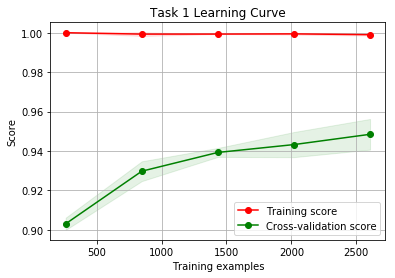

In [30]:
smile_plot = plot_learning_curve(svc_smile_rbf_NormDist_Angle_hog_plot, 'Task 1 Learning Curve',
                                 np.asarray(train_NormDist_Angle_hog), np.asarray(train_smiling),
                                 ylim=None, cv=5,
                                 n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

MLP classifier for smiling recognition

In [ ]:
n_smile = mlp_params([100, 200, 300], np.asarray(train_img_toProcess), np.asarray(train_smiling))

In [32]:
mlp_smile = MLPClassifier(hidden_layer_sizes = n_smile,
                    max_iter = 100,
                    activation = 'relu',
                    solver = 'adam',
                    alpha = 0.0001,
                    learning_rate = 'adaptive')

In [33]:
mlp_smile.fit(np.asarray(train_img_toProcess), np.asarray(train_smiling))
print('done')

done


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [34]:
pred = mlp_smile.predict(np.asarray(test_img_toProcess))

print("Final accuracy of the MLP model for smile detection is:",
mlp_smile.score(np.asarray(test_img_toProcess),
                np.asarray(test_smiling)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_smiling), pred))

Final accuracy of the MLP model for smile detection is: 0.887970615243
The confusion matrix is
[[159  74]
 [ 48 808]]


The same process is performed for all other tasks

# Task 2
The best model for age dection is MLP Classifier with 2 layers with 200 nodes in each

In [118]:
C_young_lin_landmarks = svc_lin_params(np.asarray(train_landmarks_reshape),
                                       np.asarray(train_young),
                                       [0.001, 0.01, 0.1, 0.5])

Cross-validation mean score for linear SVC with C =  0.001  is  0.799693815814
Cross-validation mean score for linear SVC with C =  0.01  is  0.799693815814
Cross-validation mean score for linear SVC with C =  0.1  is  0.799693815814
Cross-validation mean score for linear SVC with C =  0.5  is  0.799693815814
0.001
0.799693815814


In [119]:
from sklearn.metrics import confusion_matrix
print("The C coefficient used is: ", C_young_lin_landmarks)

svc_young_lin_landmarks = svm.SVC(kernel = 'linear', C = C_young_lin_landmarks)

svc_young_lin_landmarks.fit(np.asarray(train_landmarks_reshape), np.asarray(train_young))

pred = svc_young_lin_landmarks.predict(np.asarray(test_landmarks_reshape))

print("Final accuracy of the linear model for young detection, with the landmarks features is: ",
      svc_young_lin_landmarks.score(np.asarray(test_landmarks_reshape),
                                      np.asarray(test_young)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_young), pred))


The C coefficient used is:  0.001
Final accuracy of the linear model for young detection, with the landmarks features is:  0.775941230487
The confusion matrix is
[[  0 244]
 [  0 845]]


In [120]:
C_young_lin_NormDist_Angle = svc_lin_params(np.asarray(train_NormDist_Angle),
                                              np.asarray(train_young),
                                              [0.1, 0.5, 1, 3, 7, 10, 15])

Cross-validation mean score for linear SVC with C =  0.1  is  0.799693815814
Cross-validation mean score for linear SVC with C =  0.5  is  0.799693815814
Cross-validation mean score for linear SVC with C =  1  is  0.799693815814
Cross-validation mean score for linear SVC with C =  3  is  0.799693815814
Cross-validation mean score for linear SVC with C =  7  is  0.799693815814
Cross-validation mean score for linear SVC with C =  10  is  0.799693815814
Cross-validation mean score for linear SVC with C =  15  is  0.799693815814
0.1
0.799693815814


In [121]:
print("The C coefficient used is: ", C_young_lin_NormDist_Angle)

svc_young_lin_NormDist_Angle = svm.SVC(kernel = 'linear', C = C_young_lin_NormDist_Angle)

svc_young_lin_NormDist_Angle.fit(np.asarray(train_NormDist_Angle), np.asarray(train_young))

pred = svc_young_lin_NormDist_Angle.predict(np.asarray(test_NormDist_Angle))

print("Final accuracy of the linear model for young detection, with the landmark normalized disntances and angles features is: ",
      svc_young_lin_NormDist_Angle.score(np.asarray(test_NormDist_Angle),
                                         np.asarray(test_young)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_young), pred))

The C coefficient used is:  0.1
Final accuracy of the linear model for young detection, with the landmark normalized disntances and angles features is:  0.775941230487
The confusion matrix is
[[  0 244]
 [  0 845]]


In [122]:
C_young_rbf_NormDist_Angle, g_young_rbf_NormDist_Angle = svc_rbf_params(np.asarray(train_NormDist_Angle),
                                                                        np.asarray(train_young),
                                                                        [1, 3, 5, 7, 10, 15],
                                                                        [0.1, 0.5, 1, 3, 5])

Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.1  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.5  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  1  and gamma =  1  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  1  and gamma =  3  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  1  and gamma =  5  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.1  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.5  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  3  and gamma =  1  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  3  and gamma =  3  is  0.799694756763
Cross-validation mean score for rbf SVC with C =  3  and gamma =  5  is  0.80000244762
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.1  is  0.799693815814
Cross-validation mean s

In [123]:
print("The C coefficient used is: ", C_young_rbf_NormDist_Angle)
print("The gamma coefficient used is: ", g_young_rbf_NormDist_Angle)

svc_young_rbf_NormDist_Angle = svm.SVC(kernel = 'rbf', C = C_young_rbf_NormDist_Angle,
                                       gamma = g_young_rbf_NormDist_Angle)

svc_young_rbf_NormDist_Angle.fit(np.asarray(train_NormDist_Angle), np.asarray(train_young))

pred = svc_young_rbf_NormDist_Angle.predict(np.asarray(test_NormDist_Angle))

print("Final accuracy of the rbf model for young detection, with the landmark normalized disntances and angles features is: ",
      svc_young_rbf_NormDist_Angle.score(np.asarray(test_NormDist_Angle),
                                         np.asarray(test_young)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_young), pred))

The C coefficient used is:  15
The gamma coefficient used is:  5
Final accuracy of the rbf model for young detection, with the landmark normalized disntances and angles features is:  0.787878787879
The confusion matrix is
[[ 24 220]
 [ 11 834]]


In [124]:
C_young_lin_hog = svc_lin_params(np.asarray(train_hog),
                                 np.asarray(train_young),
                                 [0.5, 0.7, 0.9])

Cross-validation mean score for linear SVC with C =  0.5  is  0.800614062656
Cross-validation mean score for linear SVC with C =  0.7  is  0.807973218876
Cross-validation mean score for linear SVC with C =  0.9  is  0.812268174372
0.9
0.812268174372


In [130]:
print("The C coefficient used is: ", C_young_lin_hog)

svc_young_lin_hog = svm.SVC(kernel = 'linear', C = C_young_lin_hog)

svc_young_lin_hog.fit(np.asarray(train_hog), np.asarray(train_young))

pred = svc_young_lin_hog.predict(np.asarray(test_hog))

print("Final accuracy of the linear model for young detection, with the HOG features is: ",
      svc_young_lin_hog.score(np.asarray(test_hog),
                              np.asarray(test_young)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_young), pred))

The C coefficient used is:  0.9
Final accuracy of the linear model for young detection, with the HOG features is:  0.780532598714
The confusion matrix is
[[ 16 228]
 [ 11 834]]


In [131]:
C_young_rbf_hog, g_young_hog = svc_rbf_params(np.asarray(train_hog),
                                              np.asarray(train_young),
                                              [1, 3, 5, 6],
                                              [0.05, 0.1, 0.3, 0.4])

Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.05  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.1  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.3  is  0.803681553091
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.4  is  0.807671173709
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.05  is  0.799693815814
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.1  is  0.807975570525
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.3  is  0.815341313384
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.4  is  0.812888733469
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.05  is  0.802149220018
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.1  is  0.822387599922
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.3  is  0.80644841339
Cross-va

In [133]:
print("The C coefficient used is: ", C_young_rbf_NormDist_Angle)
print("The gamma coefficient used is: ", g_young_hog)

svc_young_rbf_hog = svm.SVC(kernel = 'rbf', C = C_young_rbf_hog, gamma = g_young_hog)

svc_young_rbf_hog.fit(np.asarray(train_hog), np.asarray(train_young))

pred = svc_young_rbf_hog.predict(np.asarray(test_hog))

print("Final accuracy of the rbf model for young detection, with the HOG features is: ",
      svc_young_rbf_hog.score(np.asarray(test_hog),
                              np.asarray(test_young)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_young), pred))

The C coefficient used is:  15
The gamma coefficient used is:  0.1
Final accuracy of the rbf model for young detection, with the HOG features is:  0.786960514233
The confusion matrix is
[[ 28 216]
 [ 16 829]]


In [35]:
n_young = mlp_params([100, 200, 300], np.asarray(train_img_toProcess), np.asarray(train_young))

C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  100  and adam activation function is  0.876996853828


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  200  and adam activation function is  0.873933133528


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  300  and adam activation function is  0.882518892001


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  100  and adam activation function is  0.878219235871


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  200  and adam activation function is  0.884049622668


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  300  and adam activation function is  0.864725877509
Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  100  and adam activation function is  0.880063115462
Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  200  and adam activation function is  0.867788185956
Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  300  and adam activation function is  0.876074631662
(200, 200)
2
0.884049622668


In [41]:
mlp_young = MLPClassifier(hidden_layer_sizes = n_young,
                    max_iter = 100,
                    activation = 'relu',
                    solver = 'adam',
                    alpha = 0.0001,
                    learning_rate = 'adaptive')
mlp_young_plot = MLPClassifier(hidden_layer_sizes = n_young,
                    max_iter = 100,
                    activation = 'relu',
                    solver = 'adam',
                    alpha = 0.0001,
                    learning_rate = 'adaptive')

In [42]:
mlp_young.fit(np.asarray(train_img_toProcess), np.asarray(train_young))
print('done')

done


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [43]:
pred = mlp_young.predict(np.asarray(test_img_toProcess))

print("Final accuracy of the MLP model for young detection is:",
mlp_young.score(np.asarray(test_img_toProcess),
                     np.asarray(test_young)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_young), pred))

Final accuracy of the MLP model for young detection is: 0.870523415978
The confusion matrix is
[[141  87]
 [ 54 807]]


In [44]:
with open('task_2.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow([mlp_young.score(np.asarray(test_img_toProcess), np.asarray(test_young))])
    #filewriter.writerow(['', ''])
    for i in range(0, len(pred)):
        filewriter.writerow([testList[i].imageInfo.image[42:], pred[i]])
        #filewriter.writerow(['', ''])

C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reache

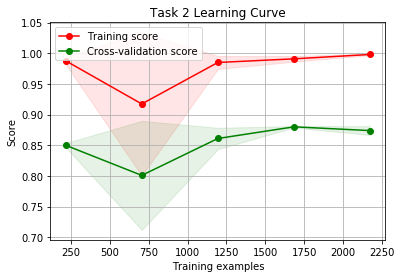

In [45]:
young_plot = plot_learning_curve(mlp_young_plot, 'Task 2 Learning Curve',
                                 np.asarray(train_img_toProcess), np.asarray(train_young),
                                 ylim=None, cv=3,
                                 n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

# Task 3
The best model for glasses detection is the SVM classifier with 'linear' kernel with C = 0.9. It decides according to the landmark normalized distances; angles and HOG image representation

In [99]:
C_glasses_lin_landmarks = svc_lin_params(np.asarray(train_landmarks_reshape),
                                         np.asarray(train_eyeglasses),
                                         [0.001, 0.01, 0.1, 0.5])

Cross-validation mean score for linear SVC with C =  0.001  is  0.863796361933
Cross-validation mean score for linear SVC with C =  0.01  is  0.884959690534
Cross-validation mean score for linear SVC with C =  0.1  is  0.877902583811
Cross-validation mean score for linear SVC with C =  0.5  is  0.876059735591
0.01
0.884959690534


In [100]:
from sklearn.metrics import confusion_matrix
print("The C coefficient used is: ", C_glasses_lin_landmarks)

svc_glasses_lin_landmarks = svm.SVC(kernel = 'linear', C = C_glasses_lin_landmarks)

svc_glasses_lin_landmarks.fit(np.asarray(train_landmarks_reshape), np.asarray(train_eyeglasses))

pred = svc_glasses_lin_landmarks.predict(np.asarray(test_landmarks_reshape))

print("Final accuracy of the linear model for eyeglasses detection, with the landmarks features is: ",
      svc_glasses_lin_landmarks.score(np.asarray(test_landmarks_reshape),
                                      np.asarray(test_eyeglasses)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_eyeglasses), pred))


The C coefficient used is:  0.01
Final accuracy of the linear model for eyeglasses detection, with the landmarks features is:  0.895316804408
The confusion matrix is
[[754  28]
 [ 86 221]]


In [101]:
C_glasses_lin_NormDist_Angle = svc_lin_params(np.asarray(train_NormDist_Angle),
                                              np.asarray(train_eyeglasses),
                                              [0.1, 0.5, 1, 3, 7, 10, 15])

Cross-validation mean score for linear SVC with C =  0.1  is  0.70950959644
Cross-validation mean score for linear SVC with C =  0.5  is  0.70950959644
Cross-validation mean score for linear SVC with C =  1  is  0.710122153867
Cross-validation mean score for linear SVC with C =  3  is  0.790490877642
Cross-validation mean score for linear SVC with C =  7  is  0.818702842988
Cross-validation mean score for linear SVC with C =  10  is  0.827908604005
Cross-validation mean score for linear SVC with C =  15  is  0.839864292579
15
0.839864292579


In [102]:
print("The C coefficient used is: ", C_glasses_lin_NormDist_Angle)

svc_glasses_lin_NormDist_Angle = svm.SVC(kernel = 'linear', C = C_glasses_lin_NormDist_Angle)

svc_glasses_lin_NormDist_Angle.fit(np.asarray(train_NormDist_Angle), np.asarray(train_eyeglasses))

pred = svc_glasses_lin_NormDist_Angle.predict(np.asarray(test_NormDist_Angle))

print("Final accuracy of the linear model for eyeglasses detection, with the landmark normalized disntances and angles features is: ",
      svc_glasses_lin_NormDist_Angle.score(np.asarray(test_NormDist_Angle),
                                           np.asarray(test_eyeglasses)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_eyeglasses), pred))

The C coefficient used is:  15
Final accuracy of the linear model for eyeglasses detection, with the landmark normalized disntances and angles features is:  0.853994490358
The confusion matrix is
[[759  23]
 [136 171]]


In [103]:
C_glasses_rbf_NormDist_Angle, g_glasses_rbf_NormDist_Angle = svc_rbf_params(np.asarray(train_NormDist_Angle),
                                                                            np.asarray(train_eyeglasses),
                                                                            [1, 3, 5, 7, 10, 15],
                                                                            [0.1, 0.5, 1, 3, 5])

Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.1  is  0.70950959644
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.5  is  0.724229789333
Cross-validation mean score for rbf SVC with C =  1  and gamma =  1  is  0.761046262639
Cross-validation mean score for rbf SVC with C =  1  and gamma =  3  is  0.802454559226
Cross-validation mean score for rbf SVC with C =  1  and gamma =  5  is  0.815024681351
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.1  is  0.70950959644
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.5  is  0.7920265062
Cross-validation mean score for rbf SVC with C =  3  and gamma =  1  is  0.814106319293
Cross-validation mean score for rbf SVC with C =  3  and gamma =  3  is  0.837424416189
Cross-validation mean score for rbf SVC with C =  3  and gamma =  5  is  0.846322490678
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.1  is  0.711043812853
Cross-validation mean scor

In [105]:
print("The C coefficient used is: ", C_glasses_rbf_NormDist_Angle)
print("The gamma coefficient used is: ", g_glasses_rbf_NormDist_Angle)

svc_glasses_rbf_NormDist_Angle = svm.SVC(kernel = 'rbf', C = C_glasses_rbf_NormDist_Angle,
                                         gamma = g_glasses_rbf_NormDist_Angle)

svc_glasses_rbf_NormDist_Angle.fit(np.asarray(train_NormDist_Angle), np.asarray(train_eyeglasses))

pred = svc_glasses_rbf_NormDist_Angle.predict(np.asarray(test_NormDist_Angle))

print("Final accuracy of the rbf model for eyeglasses detection, with the landmark normalized disntances and angles features is: ",
      svc_glasses_rbf_NormDist_Angle.score(np.asarray(test_NormDist_Angle),
                                           np.asarray(test_eyeglasses)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_eyeglasses), pred))

The C coefficient used is:  15
The gamma coefficient used is:  5
Final accuracy of the rbf model for eyeglasses detection, with the landmark normalized disntances and angles features is:  0.880624426079
The confusion matrix is
[[744  38]
 [ 92 215]]


In [106]:
C_glasses_lin_hog = svc_lin_params(np.asarray(train_hog),
                                   np.asarray(train_eyeglasses),
                                   [0.5, 0.7, 0.9])

Cross-validation mean score for linear SVC with C =  0.5  is  0.947544974629
Cross-validation mean score for linear SVC with C =  0.7  is  0.949690806078
Cross-validation mean score for linear SVC with C =  0.9  is  0.952144798138
0.9
0.952144798138


In [107]:
print("The C coefficient used is: ", C_glasses_lin_hog)

svc_glasses_lin_hog = svm.SVC(kernel = 'linear', C = C_smile_lin_hog)

svc_glasses_lin_hog.fit(np.asarray(train_hog), np.asarray(train_eyeglasses))

pred = svc_glasses_lin_hog.predict(np.asarray(test_hog))

print("Final accuracy of the linear model for eyeglasses detection, with the HOG features is: ",
      svc_glasses_lin_hog.score(np.asarray(test_hog),
                                np.asarray(test_eyeglasses)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_eyeglasses), pred))

The C coefficient used is:  0.9
Final accuracy of the linear model for eyeglasses detection, with the HOG features is:  0.949494949495
The confusion matrix is
[[779   3]
 [ 52 255]]


In [108]:
C_glasses_rbf_hog, g_glasses_hog = svc_rbf_params(np.asarray(train_hog),
                                                  np.asarray(train_eyeglasses),
                                                  [1, 3, 5, 6],
                                                  [0.05, 0.1, 0.3, 0.4])

Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.05  is  0.926689800865
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.1  is  0.934666687564
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.3  is  0.938653481006
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.4  is  0.934058360797
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.05  is  0.940186286719
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.1  is  0.947852191405
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.3  is  0.948161294407
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.4  is  0.942643101623
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.05  is  0.946319388579
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.1  is  0.950305713712
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.3  is  0.949079188156
Cross-v

In [109]:
print("The C coefficient used is: ", C_glasses_rbf_NormDist_Angle)
print("The gamma coefficient used is: ", g_glasses_hog)

svc_glasses_rbf_hog = svm.SVC(kernel = 'rbf', C = C_glasses_rbf_hog, gamma = g_glasses_hog)

svc_glasses_rbf_hog.fit(np.asarray(train_hog), np.asarray(train_eyeglasses))

pred = svc_glasses_rbf_hog.predict(np.asarray(test_hog))

print("Final accuracy of the rbf model for eyeglasses detection, with the HOG features is: ",
      svc_glasses_rbf_hog.score(np.asarray(test_hog),
                                np.asarray(test_eyeglasses)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_eyeglasses), pred))

The C coefficient used is:  15
The gamma coefficient used is:  0.1
Final accuracy of the rbf model for eyeglasses detection, with the HOG features is:  0.951331496786
The confusion matrix is
[[777   5]
 [ 48 259]]


In [46]:
C_glasses_lin_NormDist_Angle_hog = svc_lin_params(np.asarray(train_NormDist_Angle_hog),
                                                  np.asarray(train_eyeglasses),
                                                  [0.5, 0.7, 0.9])

Cross-validation mean score for linear SVC with C =  0.5  is  0.949693251534
Cross-validation mean score for linear SVC with C =  0.7  is  0.953067484663
Cross-validation mean score for linear SVC with C =  0.9  is  0.955828220859
0.9
0.955828220859


In [52]:
print("The C coefficient used is: ", C_glasses_lin_NormDist_Angle_hog)

svc_glasses_lin_NormDist_Angle_hog = svm.SVC(kernel = 'linear', C = C_glasses_lin_NormDist_Angle_hog)
svc_glasses_lin_NormDist_Angle_hog_plot = svm.SVC(kernel = 'linear', C = C_glasses_lin_NormDist_Angle_hog)


svc_glasses_lin_NormDist_Angle_hog.fit(np.asarray(train_NormDist_Angle_hog), np.asarray(train_eyeglasses))

pred = svc_glasses_lin_NormDist_Angle_hog.predict(np.asarray(test_NormDist_Angle_hog))

print("Final accuracy of the linear model for eyeglasses detection with the landmark normalized distances, Angles and HOG features is: ",
      svc_glasses_lin_NormDist_Angle_hog.score(np.asarray(test_NormDist_Angle_hog),
                                               np.asarray(test_eyeglasses)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_eyeglasses), pred))

The C coefficient used is:  0.9
Final accuracy of the linear model for eyeglasses detection with the landmark normalized distances, Angles and HOG features is:  0.966023875115
The confusion matrix is
[[768   2]
 [ 35 284]]


In [53]:
with open('task_3.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow([svc_glasses_lin_NormDist_Angle_hog.score(np.asarray(test_NormDist_Angle_hog), np.asarray(test_eyeglasses))])
    #filewriter.writerow(['', ''])
    for i in range(0, len(pred)):
        filewriter.writerow([testList[i].imageInfo.image[42:], pred[i]])
        #filewriter.writerow(['', ''])

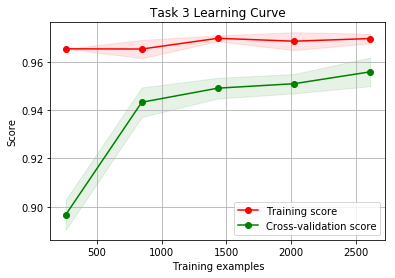

In [54]:
glasses_plot = plot_learning_curve(svc_glasses_lin_NormDist_Angle_hog_plot, 'Task 3 Learning Curve',
                                 np.asarray(train_NormDist_Angle_hog), np.asarray(train_eyeglasses),
                                 ylim=None, cv=5,
                                 n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

In [112]:
C_glasses_rbf_NormDist_Angle_hog, g_glasses_NormDist_Angle_hog = svc_rbf_params(np.asarray(train_NormDist_Angle_hog),
                                                                                np.asarray(train_eyeglasses),
                                                                                [1, 3, 5, 6],
                                                                                [0.05, 0.1, 0.3, 0.4])

Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.05  is  0.926074893232
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.1  is  0.933439690812
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.3  is  0.936811576621
Cross-validation mean score for rbf SVC with C =  1  and gamma =  0.4  is  0.93282431054
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.05  is  0.942334943899
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.1  is  0.946934768851
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.3  is  0.944480776792
Cross-validation mean score for rbf SVC with C =  3  and gamma =  0.4  is  0.940494919968
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.05  is  0.948775733731
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.1  is  0.952453898253
Cross-validation mean score for rbf SVC with C =  5  and gamma =  0.3  is  0.948776203484
Cross-va

In [113]:
print("The C coefficient used is: ", C_glasses_rbf_NormDist_Angle_hog)
print("The gamma coefficient used is: ", g_glasses_NormDist_Angle_hog)

svc_glasses_rbf_NormDist_Angle_hog = svm.SVC(kernel = 'rbf', C = C_glasses_rbf_NormDist_Angle_hog,
                                             gamma = g_glasses_NormDist_Angle_hog)

svc_glasses_rbf_NormDist_Angle_hog.fit(np.asarray(train_NormDist_Angle_hog), np.asarray(train_eyeglasses))

pred = svc_glasses_rbf_NormDist_Angle_hog.predict(np.asarray(test_NormDist_Angle_hog))

print("Final accuracy of the rbf model for eyeglasses detection with the landmark normalized distances, Angles and HOG features is: ",
      svc_glasses_rbf_NormDist_Angle_hog.score(np.asarray(test_NormDist_Angle_hog),
                                               np.asarray(test_eyeglasses)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_eyeglasses), pred))

The C coefficient used is:  6
The gamma coefficient used is:  0.1
Final accuracy of the rbf model for eyeglasses detection with the landmark normalized distances, Angles and HOG features is:  0.955004591368
The confusion matrix is
[[777   5]
 [ 44 263]]


In [48]:
n_eyeglasses = mlp_params([100, 200, 300], np.asarray(train_img_toProcess), np.asarray(train_eyeglasses))

C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  100  and adam activation function is  0.841418166478


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  200  and adam activation function is  0.862886515847


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  300  and adam activation function is  0.848776460237


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  100  and adam activation function is  0.857671414445


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  200  and adam activation function is  0.847245729569


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  300  and adam activation function is  0.846016853003


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  100  and adam activation function is  0.850611586341
Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  200  and adam activation function is  0.861658204022


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  300  and adam activation function is  0.799409054945
200
1
0.862886515847


In [49]:
mlp_eyeglasses = MLPClassifier(hidden_layer_sizes = n_eyeglasses,
                    max_iter = 100,
                    activation = 'relu',
                    solver = 'adam',
                    alpha = 0.0001,
                    learning_rate = 'adaptive')

In [50]:
mlp_eyeglasses.fit(np.asarray(train_img_toProcess), np.asarray(train_eyeglasses))
print('done')

done


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [51]:
pred = mlp_eyeglasses.predict(np.asarray(test_img_toProcess))

print("Final accuracy of the MLP model for eyeglasses detection is:",
mlp_eyeglasses.score(np.asarray(test_img_toProcess),
                     np.asarray(test_eyeglasses)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_eyeglasses), pred))

Final accuracy of the MLP model for eyeglasses detection is: 0.877869605142
The confusion matrix is
[[723  47]
 [ 86 233]]


# Task 4
The best model for human recognition is the MLP classifier with 3 layers with 300 nodes in each

In [114]:
C_human_lin_landmarks = svc_lin_params(np.asarray(train_landmarks_reshape),
                                       np.asarray(train_human),
                                       [0.001, 0.01, 0.1, 0.5])

Cross-validation mean score for linear SVC with C =  0.001  is  0.976380346451
Cross-validation mean score for linear SVC with C =  0.01  is  0.983435098638
Cross-validation mean score for linear SVC with C =  0.1  is  0.984663504647
Cross-validation mean score for linear SVC with C =  0.5  is  0.978527588601
0.1
0.984663504647


In [115]:
from sklearn.metrics import confusion_matrix
print("The C coefficient used is: ", C_human_lin_landmarks)

svc_human_lin_landmarks = svm.SVC(kernel = 'linear', C = C_human_lin_landmarks)

svc_human_lin_landmarks.fit(np.asarray(train_landmarks_reshape), np.asarray(train_human))

pred = svc_human_lin_landmarks.predict(np.asarray(test_landmarks_reshape))

print("Final accuracy of the linear model for human detection, with the landmarks features is: ",
      svc_human_lin_landmarks.score(np.asarray(test_landmarks_reshape),
                                    np.asarray(test_human)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_human), pred))


The C coefficient used is:  0.1
Final accuracy of the linear model for human detection, with the landmarks features is:  0.987144168962
The confusion matrix is
[[608  10]
 [  4 467]]


In [116]:
C_human_lin_NormDist_Angle = svc_lin_params(np.asarray(train_NormDist_Angle),
                                            np.asarray(train_human),
                                            [0.1, 0.5, 1, 3, 7, 10, 15])

Cross-validation mean score for linear SVC with C =  0.1  is  0.886817715155
Cross-validation mean score for linear SVC with C =  0.5  is  0.922093343556
Cross-validation mean score for linear SVC with C =  1  is  0.930371324371
Cross-validation mean score for linear SVC with C =  3  is  0.942335936802
Cross-validation mean score for linear SVC with C =  7  is  0.954301491624
Cross-validation mean score for linear SVC with C =  10  is  0.95736850942
Cross-validation mean score for linear SVC with C =  15  is  0.962275549705
15
0.962275549705


In [117]:
print("The C coefficient used is: ", C_human_lin_NormDist_Angle)

svc_human_lin_NormDist_Angle = svm.SVC(kernel = 'linear', C = C_human_lin_NormDist_Angle)

svc_human_lin_NormDist_Angle.fit(np.asarray(train_NormDist_Angle), np.asarray(train_human))

pred = svc_human_lin_NormDist_Angle.predict(np.asarray(test_NormDist_Angle))

print("Final accuracy of the linear model for human detection, with the landmark normalized disntances and angles features is: ",
      svc_human_lin_NormDist_Angle.score(np.asarray(test_NormDist_Angle),
                                         np.asarray(test_human)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_human), pred))

The C coefficient used is:  15
Final accuracy of the linear model for human detection, with the landmark normalized disntances and angles features is:  0.969696969697
The confusion matrix is
[[591  27]
 [  6 465]]


In [61]:
n_human = mlp_params([100, 200, 300], np.asarray(train_img_toProcess), np.asarray(train_human))

C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  100  and adam activation function is  0.990488909652


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  200  and adam activation function is  0.990181972881


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  300  and adam activation function is  0.992329966056
Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  100  and adam activation function is  0.991717220958
Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  200  and adam activation function is  0.988646724804
Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  300  and adam activation function is  0.991409155743
Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  100  and adam activation function is  0.992023593507
Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  200  and adam activation function is  0.990796410645
Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  300  and adam activation function is  0.9923310945
(300, 300, 300)
3
0.9923310945


In [62]:
mlp_human = MLPClassifier(hidden_layer_sizes = n_human,
                    max_iter = 100,
                    activation = 'relu',
                    solver = 'adam',
                    alpha = 0.0001,
                    learning_rate = 'adaptive')
mlp_human_plot = MLPClassifier(hidden_layer_sizes = n_human,
                    max_iter = 100,
                    activation = 'relu',
                    solver = 'adam',
                    alpha = 0.0001,
                    learning_rate = 'adaptive')

In [63]:
mlp_human.fit(np.asarray(train_img_toProcess), np.asarray(train_human))
print('done')


done


In [64]:
pred = mlp_human.predict(np.asarray(test_img_toProcess))

print("Final accuracy of the MLP model for human detection is:",
mlp_human.score(np.asarray(test_img_toProcess),
                     np.asarray(test_human)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_human), pred))

Final accuracy of the MLP model for human detection is: 0.997245179063
The confusion matrix is
[[570   3]
 [  0 516]]


In [65]:
with open('task_4.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow([mlp_human.score(np.asarray(test_img_toProcess), np.asarray(test_human))])
    #filewriter.writerow(['', ''])
    for i in range(0, len(pred)):
        filewriter.writerow([testList[i].imageInfo.image[42:], pred[i]])
        #filewriter.writerow(['', ''])

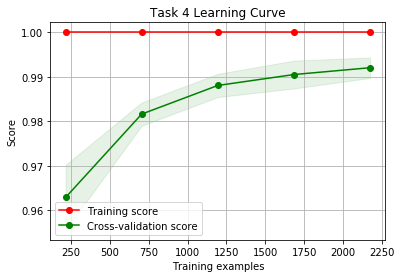

In [66]:
human_plot = plot_learning_curve(mlp_human_plot, 'Task 4 Learning Curve',
                                 np.asarray(train_img_toProcess), np.asarray(train_human),
                                 ylim=None, cv=3,
                                 n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

# Task 5
For this tasks there were images, which were labeled with -1 for hair color. The first 4 blocks remove this noise data from the training and testing sets. The process is similar to the removal of the noise data from the list of all images.

The best model for hair color detection is the MLP classifier with 3 layers with 300 nodes in each

In [67]:
j=0
removeIndex = []
for i in range (0,len(train_hair_color)):
    if (train_hair_color[i] == -1):
        removeIndex.append(i)

In [68]:
removeIndex.reverse()
for i in range (0 , len(removeIndex)):
    removeElement = train_hair_color.pop(removeIndex[i])
    removeElement = train_img_toProcess.pop(removeIndex[i])
print("done")

done


In [69]:
j=0
removeIndex = []
for i in range (0,len(test_hair_color)):
    if (test_hair_color[i] == -1):
        removeIndex.append(i)

In [70]:
removeIndex.reverse()
for i in range (0 , len(removeIndex)):
    removeElement = test_hair_color.pop(removeIndex[i])
    removeElement = test_img_toProcess.pop(removeIndex[i])
print("done")

done


In [71]:
n_hair_color = mlp_params([100, 200, 300], np.asarray(train_img_toProcess), np.asarray(train_hair_color))

C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  100  and adam activation function is  0.825051909616


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  200  and adam activation function is  0.839919200462


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  1  N(nodes) =  300  and adam activation function is  0.843565697105


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  100  and adam activation function is  0.835572966018


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  200  and adam activation function is  0.834843985535


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  2  N(nodes) =  300  and adam activation function is  0.846096411177


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  100  and adam activation function is  0.827208824182


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  200  and adam activation function is  0.840295355152


C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validation mean score for MLP N(layers) =  3  N(nodes) =  300  and adam activation function is  0.852265704994
(300, 300, 300)
3
0.852265704994


In [72]:
mlp_hair_color = MLPClassifier(hidden_layer_sizes = n_hair_color,
                    max_iter = 100,
                    activation = 'relu',
                    solver = 'adam',
                    alpha = 0.0001,
                    learning_rate = 'adaptive')
mlp_hair_color_plot = MLPClassifier(hidden_layer_sizes = n_hair_color,
                    max_iter = 100,
                    activation = 'relu',
                    solver = 'adam',
                    alpha = 0.0001,
                    learning_rate = 'adaptive')

In [73]:
mlp_hair_color.fit(np.asarray(train_img_toProcess), np.asarray(train_hair_color))
print('done')

done


In [74]:
pred = mlp_hair_color.predict(np.asarray(test_img_toProcess))

print("Final accuracy of the MLP model for hair color detection is:",
mlp_hair_color.score(np.asarray(test_img_toProcess),
                     np.asarray(test_hair_color)))
print("The confusion matrix is")
print(confusion_matrix( np.asarray(test_hair_color), pred))

Final accuracy of the MLP model for hair color detection is: 0.84903640257
The confusion matrix is
[[  3   6   2   5   4   5]
 [  5 216   1  17   0   1]
 [  0   3 107   6   0   0]
 [  0   6   5 207   6   3]
 [  1   0   1  43 149   0]
 [  3  10   0   6   2 111]]


In [77]:
with open('task_5.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow([mlp_hair_color.score(np.asarray(test_img_toProcess), np.asarray(test_hair_color))])
    #filewriter.writerow(['', ''])
    for i in range(0, len(pred)):
        filewriter.writerow([testList[i].imageInfo.image[42:], pred[i]])
        #filewriter.writerow(['', ''])

C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ching\Anaconda3\envs\Assignment_1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reache

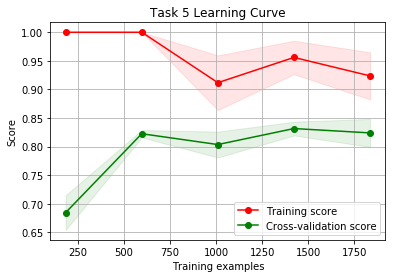

In [78]:
hair_plot = plot_learning_curve(mlp_hair_color_plot, 'Task 5 Learning Curve',
                                 np.asarray(train_img_toProcess), np.asarray(train_hair_color),
                                 ylim=None, cv=3,
                                 n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

# Additional data evaluation

Additional data evaluation from the testing_dataset includes: the extraction of the features from the provided images, application of the models chosen in the previous tasks to assess the new images.

The defined function to read and extract the landmarks is changes from the original in a way that the images are assessd not in a numerical order, and the location of the images is changed.

In [85]:
# This block is based on the landmarks.py code from the Applied Machine Learning Systems
# Laboratory Exercise 2. The difference is in the image_path definition. In this version
# The image paths are extracted in numerical order from 1.png to 5000.png


#Definition of the folder, where the images are located
basedir = './dataset'
images_dir = "C:/Users/ching/Desktop/Assignment/testing_dataset"
#labels_filename = 'attribute_list.csv'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')


def extract_features_labels_test():

#     This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
#     It also extract the gender label for each image.
#     :return:
#         landmark_features:  an array containing 68 landmark points for each image in which a face was detected
#         gender_labels:      an array containing the gender label (male=0 and female=1) for each image in
#                             which a face was detected
  
    image_paths = []
    # Images path extraction in numerical order
#     for i in range (1, 5001):
#             imgs_path = os.path.join(imgs_dir + str(i) + ".png")
#             image_paths.extend(glob.glob(imgs_path))
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]

    target_size = None
    # Extraction of the labels from the attribute_list.csv
    labels_file = open(labels_filename, 'r')
    lines = labels_file.readlines()
    #gender_labels = {line.split(',')[0] : int(line.split(',')[6]) for line in lines[2:]}
    if os.path.isdir(images_dir):
        all_features = []       # List of landmarks coordinates for the images
        images_to_keep = []     # List of paths of the images, for which the landmarks are extracted
        images_to_remove = []   # List of paths of the images, for which the landmarks cannot be extracted
        for img_path in image_paths:
            file_name= img_path.split('.')[1].split('/')[-1]

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                images_to_keep.append(img_path)

                #all_labels.append(gender_labels[file_name])
            else:
                images_to_remove.append(img_path)

    landmark_features = np.array(all_features)
    return landmark_features, images_to_keep, images_to_remove, image_paths#, gender_labels



In [86]:
imgs_features_test, imgs_to_keep_test, imgs_to_remove_test, imgs = extract_features_labels_test()

In [15]:
create a list of Image objects

imageList_keep_test = []
j=0
for i in range (0,len(imgs)):
    landmarks=[]   #extraction of the landmarks and paths of the images to be kept
    if (j < len(imgs_to_keep_test)):
        if (imgs[i] == imgs_to_keep_test[j]):
            landmarks = imgs_features_test[j]
            j = j+1
    img = cv2.imread(imgs[i])                      # RGB 256x256x3 image array
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   # Gray image from RGB data
   
    
    imageList_keep_test.append(Image(imgs[i], -1,     # The object is created and appended to the list.
                          -1,                         # As the new images have no labels, -1 are applied
                          -1,                         # However, these values are not used
                          -1,
                          -1,
                          landmarks,
                          img,
                          gray))
print("done")

done


There are images, tho which the landmarks cannot be assigned. Therefore, it's impossible to extract the features, required to the trained SVM's to predict the results. Therefore, MLP models created for the task are used for these images

In [135]:
imageList_keep_test_noLandmarks=[]

imageList_keep_test_noLandmarks.append(np.concatenate((imageList_keep_test, imageList_keep_test_noLandmarks), axis = 0))


In [136]:
imageList_keep_test_noLandmarks_1 = []
for i in range(0, len(imageList_keep_test)):
    imageList_keep_test_noLandmarks_1.append(imageList_keep_test_noLandmarks[0][i])

In [137]:
j=0
removeIndex = []
for i in range (0,len(imgs)):
    if (j < len(imgs_to_remove_test)):
        if (imageList_keep_test[i].image == imgs_to_remove_test[j]):
            removeIndex.append(i)
            j = j+1
        #elif (imageList[i].hair_color == -1):
            #removeIndex.append(i)

The following block removes the images from the 'imageList'
It is done in the reverse order, so that the last images are
removed first, so that the indexes of the first images are not
changing.

In [139]:
removeIndex.reverse()
for i in range (0 , len(removeIndex)):
    removeElement = imageList_keep_test.pop(removeIndex[i])
print("done")


done


In [153]:
np.shape(imageList_keep_test_noLandmarks)[1]

100

In [143]:
j=0
removeIndex = []
for i in range (0,len(imgs)):
    if (j < len(imgs_to_keep_test)):
        if (imageList_keep_test_noLandmarks_1[i].image == imgs_to_keep_test[j]):
            removeIndex.append(i)
            j = j+1
        #elif (imageList[i].hair_color == -1):
            #removeIndex.append(i)

The following block removes the images from the 'imageList'
It is done in the reverse order, so that the last images are
removed first, so that the indexes of the first images are not
changing.

In [144]:
removeIndex.reverse()
for i in range (0 , len(removeIndex)):
    removeElement = imageList_keep_test_noLandmarks_1.pop(removeIndex[i])
print("done")


done


In [145]:
np.shape(imageList_keep_test_noLandmarks_1)

(4,)

In [147]:
imageToProcessList_test = []
j=0
for i in range (0,len(imageList_keep_test)):

    # Extract Histogram of Oriented Gradients from the image.
    # The parameters were chosen experimentally. These parameters
    # result to the high accuracy and good learning speed of the
    # learning algorithms. The parameters can be changed, if needed
    # for future purposes.
    (hog, hogImage) = feature.hog(imageList_keep_test[i].gray, orientations=9, pixels_per_cell=(32, 32),
                            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualise=True)
 
    # 'hogImage' to visualize the HOG representation of the image
    # if needed
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")
    
    # Face center coordinates are obtaine as the mean x and y values
    # of all the detected landmarks coordinates
    faceCenter = np.mean(imageList_keep_test[i].landmarks,axis=0)
    
    # Variables to keep the Distances of the landmarks from the face center,
    # and angles of the (center --->landmark) vectors
    landmarkDistance = []
    landmarkNormDistance = []
    landmarkAngle = []
    
    # Maximum and minimum x and y coordinate are extracted from the landmarks
    # coordinates. These are used to calculate normalized distances
    # distance = ((x_center - x)^2 + (y_center - y)^2)^0.5
    # maxDistance = ((xmax - xmin)^2 + (ymax - ymin)^2)^0.5
    # normDistance = distance/maxDistance
    xmax = imageList_keep_test[i].landmarks[0][0]
    xmin = imageList_keep_test[i].landmarks[0][0]
    ymax = imageList_keep_test[i].landmarks[0][1]
    ymin = imageList_keep_test[i].landmarks[0][1]
    for l in range(0, len(imageList_keep_test[i].landmarks)):
        if (imageList_keep_test[i].landmarks[l][0] > xmax):
            xmax = imageList_keep_test[i].landmarks[l][0]
        if (imageList_keep_test[i].landmarks[l][0] < xmin):
            xmin = imageList_keep_test[i].landmarks[l][0]
        if (imageList_keep_test[i].landmarks[l][1] > ymax):
            ymax = imageList_keep_test[i].landmarks[l][1]
        if (imageList_keep_test[i].landmarks[l][1] < ymin):
            ymin = imageList_keep_test[i].landmarks[l][1]
    maxDist = math.sqrt(pow(xmax - xmin, 2) + pow(ymax - ymin, 2))
    
    
    for j in range (0, len(imageList_keep_test[i].landmarks)):
        landmarkDistance.append((math.sqrt(pow(faceCenter[0] - imageList_keep_test[i].landmarks[j][0], 2) 
                                           + pow(faceCenter[1] - imageList_keep_test[i].landmarks[j][1], 2))))
        
        landmarkNormDistance.append((math.sqrt(pow(faceCenter[0] - imageList_keep_test[i].landmarks[j][0], 2) 
                                           + pow(faceCenter[1] - imageList_keep_test[i].landmarks[j][1], 2)))/maxDist)
        
        landmarkAngle.append(((math.atan2(faceCenter[1] - imageList_keep_test[i].landmarks[j][1],
                                        faceCenter[0] - imageList_keep_test[i].landmarks[j][0])*360)/(2*math.pi) + 180)/360)
    
    imageToProcessList_test.append(ImageToProcess(imageList_keep_test[i],
                                             hog,hogImage,
                                             faceCenter,
                                             landmarkDistance,
                                             landmarkNormDistance,
                                             landmarkAngle))
print("done")

done


In [148]:
img = [o.imageInfo.img for o in imageToProcessList_test]
print(np.shape(img))

img_noLandmarks = [o.img for o in imageList_keep_test_noLandmarks_1]
print(np.shape(img_noLandmarks))

gray = [o.imageInfo.gray for o in imageToProcessList_test]
print(np.shape(gray))

landmarks = [o.imageInfo.landmarks for o in imageToProcessList_test]
print(np.shape(landmarks))

hog = [o.hog for o in imageToProcessList_test]
print(np.shape(hog))

NormDist = [o.landmarkNormDistance for o in imageToProcessList_test]
print(np.shape(NormDist))

Angle = [o.landmarkAngle for o in imageToProcessList_test]
print(np.shape(Angle))

(96, 256, 256, 3)
(4, 256, 256, 3)
(96, 256, 256)
(96, 68, 2)
(96, 1764)
(96, 68)
(96, 68)


In [149]:
NormDist_Angle_hog = []
NormDist_Angle = []
for i in range (0, len(NormDist)):
    NormDist_Angle.append(np.concatenate((NormDist[i], Angle[i]), axis = 0))
    NormDist_Angle_hog.append(np.concatenate((NormDist_Angle[i], hog[i]), axis = 0))
print(np.shape(NormDist))
print(np.shape(Angle))
print(np.shape(NormDist_Angle))
print(np.shape(NormDist_Angle_hog))


(96, 68)
(96, 68)
(96, 136)
(96, 1900)


In [150]:
img_toProcess = img_reshape(28,28,img)
img_toProcess_noLandmarks = img_reshape(28,28,img_noLandmarks)

(96, 2352)
(4, 2352)


Prediction of the results for each task for the new testing dataset. For the images, to where the landmarks could not be appied, are used with the MLP models trained for each task.

In [151]:
smile_pred = svc_smile_rbf_NormDist_Angle_hog.predict(np.asarray(NormDist_Angle_hog))

smile_pred_noLandmarks = mlp_smile.predict(np.asarray(img_toProcess_noLandmarks))

young_pred = mlp_young.predict(np.asarray(img_toProcess))

young_pred_noLandmarks = mlp_young.predict(np.asarray(img_toProcess_noLandmarks))

glasses_pred = svc_glasses_lin_NormDist_Angle_hog.predict(np.asarray(NormDist_Angle_hog))

glasses_pred_noLandmarks = mlp_eyeglasses.predict(np.asarray(img_toProcess_noLandmarks))

human_pred = mlp_human.predict(np.asarray(img_toProcess))

human_pred_noLandmarks = mlp_human.predict(np.asarray(img_toProcess_noLandmarks))

hair_pred = mlp_hair_color.predict(np.asarray(img_toProcess))

hair_pred_noLandmarks = mlp_hair_color.predict(np.asarray(img_toProcess_noLandmarks))


Creation of the new csv file, which will contain all the results for the additional testing dataset

In [157]:
with open('additional_Test.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    #filewriter.writerow(['', ''])
    filewriter.writerow([np.shape(imageList_keep_test_noLandmarks)[1]])
    filewriter.writerow(['file_name', 'smiling', 'young', 'eyeglasses', 'human', 'hair_color'])
    for i in range(0, len(smile_pred)):
        filewriter.writerow([imageToProcessList_test[i].imageInfo.image[50:],
                             smile_pred[i],
                             young_pred[i],
                             glasses_pred[i],
                             human_pred[i],
                             hair_pred[i]])
    for i in range(0, len(smile_pred_noLandmarks)):
        filewriter.writerow([imageList_keep_test_noLandmarks_1[i].image[50:],
                             smile_pred_noLandmarks[i],
                             young_pred_noLandmarks[i],
                             glasses_pred_noLandmarks[i],
                             human_pred_noLandmarks[i],
                             hair_pred_noLandmarks[i]])
        
        #filewriter.writerow(['', ''])